In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler


In [78]:
tf.random.set_seed(42)

In [79]:
stock = pd.read_csv(r'Stocks/a.us.txt')
stock = stock[['Date', 'Close']]
stock

,Date,Close
0,1999-11-18,29.702
1,1999-11-19,27.257
2,1999-11-22,29.702
3,1999-11-23,27.002
4,1999-11-24,27.717
...,...,...
4516,2017-11-06,68.220
4517,2017-11-07,68.250
4518,2017-11-08,68.110
4519,2017-11-09,67.470


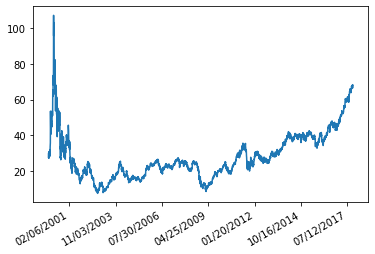

In [80]:
# Plotting the data
import datetime as dt

x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in stock['Date']]

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1000))
plt.plot(x, stock['Close'])
plt.gcf().autofmt_xdate()


In [85]:
from sklearn.preprocessing import MinMaxScaler

# making the dataset stationary
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset['Close'][i] - dataset['Close'][i - interval]
        diff.append(value)
    return pd.Series(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]



# Transforming the dataset into -1 and +1 values for the tanh activation function
def scale_dataset(X):
    X = X.reshape(len(X), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(X)
    scaled_X = scaler.transform(X)
    scaled_series = pd.Series(scaled_X[:, 0])
    return scaled_series, scaler



In [94]:
def get_train_test(dataset, train_test_ratio, n_days):
    n_train = int(len(dataset)*train_test_ratio)
    l = []
    l.append('id')
    for j in range(1, n_days+1):
        l.append(f'Price_{j}_db')
    l.append('Price_today')
    X = pd.DataFrame(columns=l)
    for i in range(n_days, len(dataset)):
        row = pd.DataFrame()
        row['id'] = [i-n_days]
        for j in range(1, n_days + 1):
            row[f'Price_{j}_db'] = [dataset[i-j]]
        row['Price_today'] = [dataset[i]]
        X = pd.concat([X,row], ignore_index=True)
    X = X.set_index('id', drop=True)    
    train = X[:n_train]
    test = X[n_train:-1]
    return train, test

In [95]:
# diff_dataset = difference(stock)
scaled_dataset, scaler = scale_dataset(stock['Close'].to_numpy())
train, test = get_train_test(scaled_dataset, 0.8, 5)

train_y = train['Price_today']
train_X = train.drop(['Price_today'], axis=1)

test_y = test['Price_today']
test_X = train.drop(['Price_today'], axis=1)


In [97]:
def fit_lstm(train_X, train_y, batch_size, n_epochs, n_neurons):
    train_y = train_y.to_numpy()
    train_X = train_X.to_numpy()
    train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
    model = Sequential()
    model.add(LSTM(n_neurons, activation='relu', input_shape=(train_X.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, verbose=1, shuffle=False)

    return model, history

In [98]:
model, history = fit_lstm(train_X, train_y, batch_size=1, n_epochs=50, n_neurons=5)

Epoch 1/50
3616/3616 [==============================] - 8s 2ms/step - loss: 0.0045
Epoch 2/50
3616/3616 [==============================] - 7s 2ms/step - loss: 0.0023
Epoch 3/50
3616/3616 [==============================] - 7s 2ms/step - loss: 0.0020
Epoch 4/50
3616/3616 [==============================] - 7s 2ms/step - loss: 0.0018
Epoch 5/50
3616/3616 [==============================] - 7s 2ms/step - loss: 0.0018
Epoch 6/50
3616/3616 [==============================] - 7s 2ms/step - loss: 0.0018
Epoch 7/50
3616/3616 [==============================] - 7s 2ms/step - loss: 0.0018
Epoch 8/50
3616/3616 [==============================] - 7s 2ms/step - loss: 0.0019
Epoch 9/50
3616/3616 [==============================] - 7s 2ms/step - loss: 0.0018
Epoch 10/50
3616/3616 [==============================] - 7s 2ms/step - loss: 0.0019
Epoch 11/50
3616/3616 [==============================] - 8s 2ms/step - loss: 0.0019
Epoch 12/50
3616/3616 [==============================] - 7s 2ms/step - loss: 0.0018
E

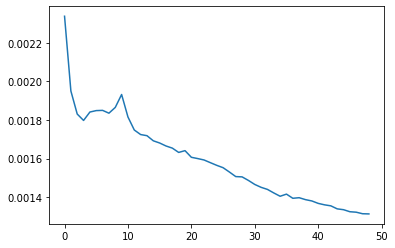

In [99]:
# Plotting the loss throughout the epochs 
plt.plot(history.history['loss'][1:])
plt.show()

In [110]:
stock[2020:2026]['Close']

2020    25.659
2021    25.576
2022    24.619
2023    25.036
2024    24.949
2025    24.511
Name: Close, dtype: float64

In [108]:
def predict_value(days_before, scaler, model):
    db = days_before.to_numpy()
    db = db.reshape(len(db), 1)
    scaled_db = scaler.transform(db)
    scaled_predicted_price = model.predict(scaled_db)
    predicted_price = scaler.inverse_transform(scaled_predicted_price)
    return predicted_price

In [109]:
predict_value(stock[2020:2025]['Close'], scaler, model)

array([[47.92766 ],
       [47.91221 ],
       [47.75695 ],
       [47.811604],
       [47.795383]], dtype=float32)